# Import Libraries and Load the Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# note: those to be used for classification will be imported as needed.

# get the directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/advertising/advertising.csv


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
ad = pd.read_csv('/kaggle/input/advertising/advertising.csv')
ad.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [4]:
ad.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 342.5 KB


In [5]:
# converting the datatype of 'timestamp'
ad.Timestamp = pd.to_datetime(ad.Timestamp)

# confirming that there are no null values
ad.isna().sum()

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Male                        0
Country                     0
Timestamp                   0
Clicked on Ad               0
dtype: int64

In [6]:
ad.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,65.000200,36.009000,55000.000080,180.000100,0.481000,0.50000
std,15.853615,8.785562,13414.634022,43.902339,0.499889,0.50025
min,32.600000,19.000000,13996.500000,104.780000,0.000000,0.00000
25%,51.360000,29.000000,47031.802500,138.830000,0.000000,0.00000
50%,68.215000,35.000000,57012.300000,183.130000,0.000000,0.50000
75%,78.547500,42.000000,65470.635000,218.792500,1.000000,1.00000
max,91.430000,61.000000,79484.800000,269.960000,1.000000,1.00000


## Main ideas:
* explore the dataset
* preprocess the data
* create a **logistic regression model**, use it for predictions and evaluate its performance
* scale the dataset, build a **KNN model**, get and evaluate the performance. Find the best k-value based on the error rate, tune the model and re-run it
* compare the performance of both models

# Exploratory Data Analysis

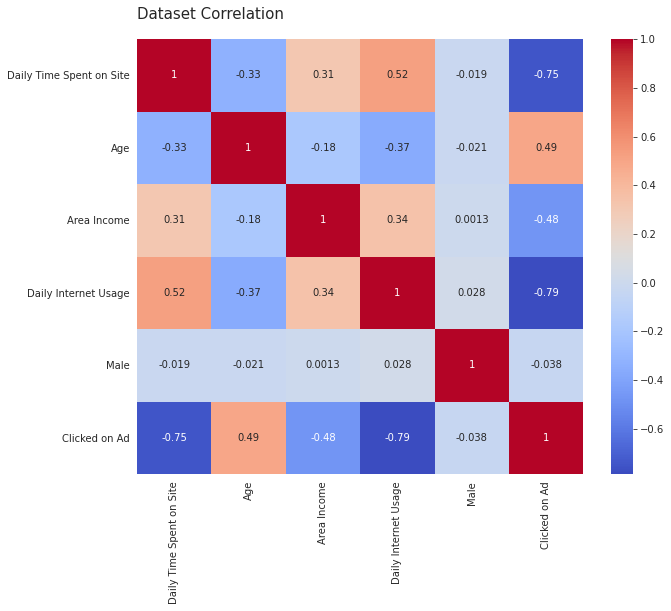

In [7]:
sns.set_style('whitegrid')

plt.figure(figsize=(10,8))
sns.heatmap(ad.corr(), annot=True, cmap='coolwarm');
plt.title('Dataset Correlation', loc='left', pad=20, fontsize=15);

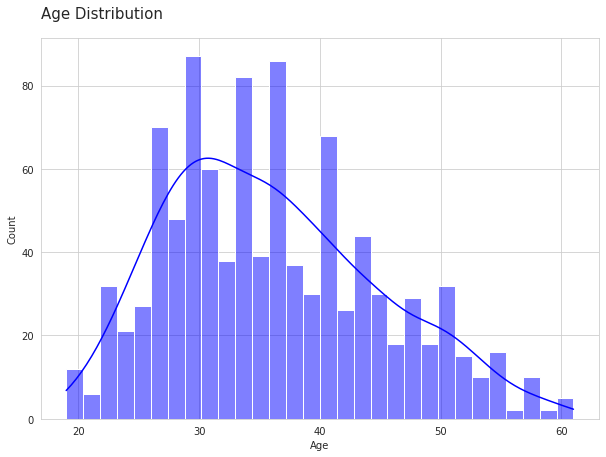

In [8]:
plt.figure(figsize=(10, 7));

sns.histplot(ad.Age,bins=30,kde=True, color='b');
plt.title('Age Distribution', loc='left', fontsize=15, pad=20);

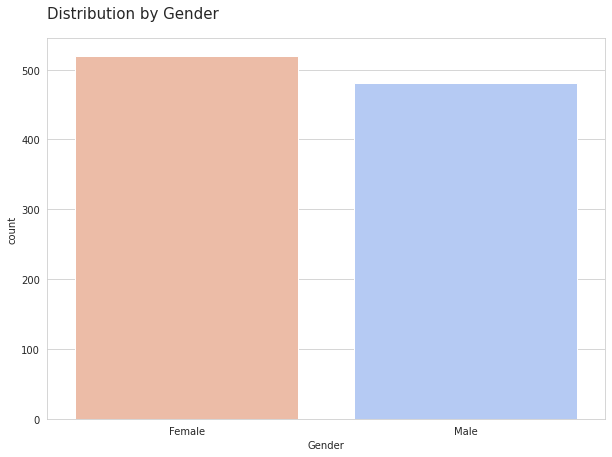

In [9]:
plt.figure(figsize=(10, 7));

xplot = ad.Male.apply(lambda x: 'Female' if x == 0 else 'Male')
sns.countplot(xplot, palette='coolwarm_r');
plt.xlabel('Gender');
plt.title('Distribution by Gender', loc='left', fontsize=15, pad=20);

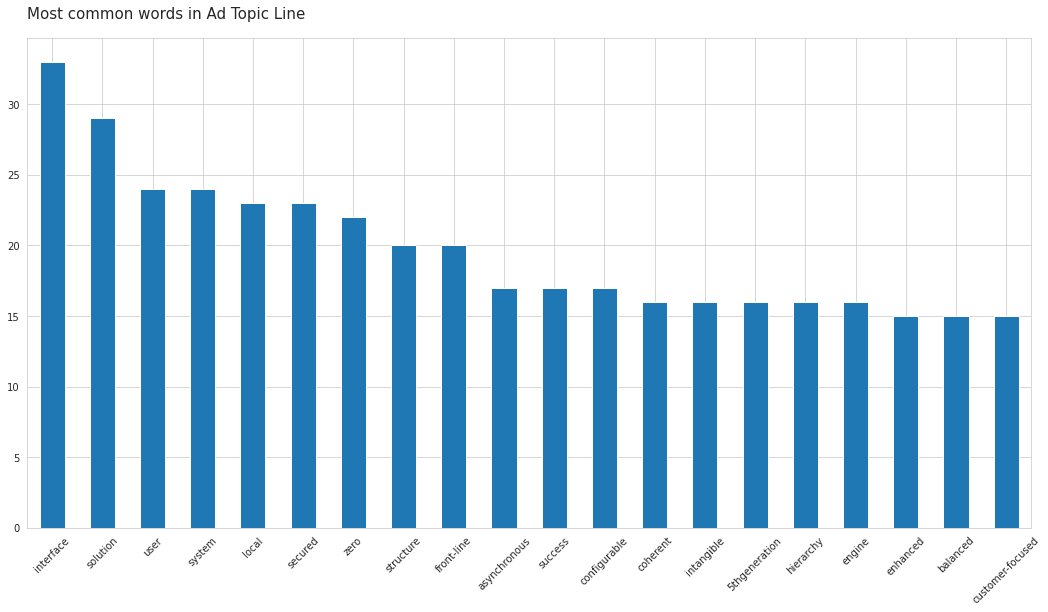

In [10]:
# getting the most common words in the ad topic line. Using value_counts i/o Counter for performance sake

plt.figure(figsize=(18, 9))
pd.Series(' '.join(ad['Ad Topic Line']).lower().split()).value_counts()[:20].plot(kind='bar');
plt.xticks(rotation=45);
plt.title('Most common words in Ad Topic Line', loc='left', pad=20, fontsize=15);

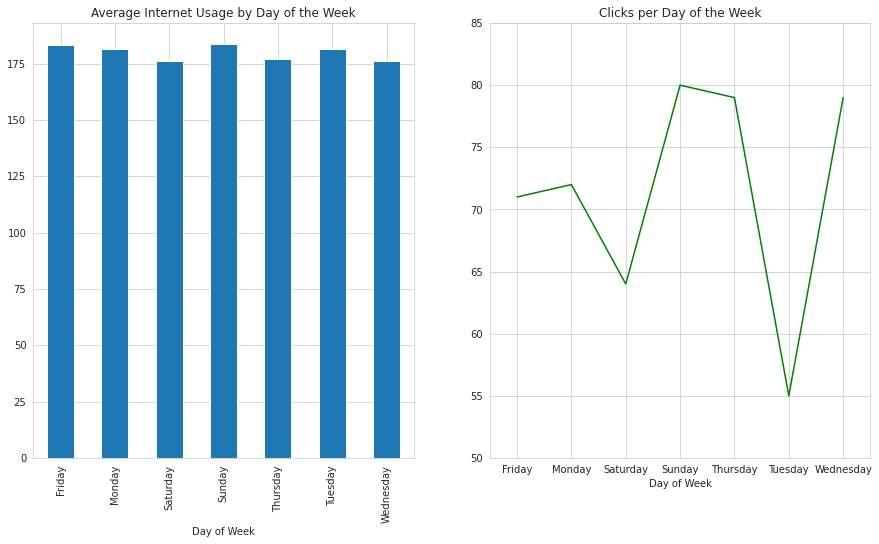

In [11]:
y = ad.copy()
y['Day of Week'] = y.Timestamp.dt.day_name()

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(15, 8));

y.groupby('Day of Week')['Daily Internet Usage'].mean().plot(kind='bar', ax=ax1)
y.groupby('Day of Week')['Clicked on Ad'].sum().plot(kind='line', color='g', ax=ax2)
ax1.title.set_text('Average Internet Usage by Day of the Week');
ax2.title.set_text('Clicks per Day of the Week');
ax2.set_ylim([50,85]);

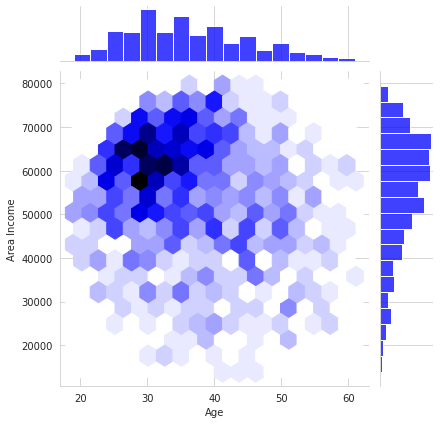

In [12]:
# age vs. area income
sns.jointplot(x='Age', y='Area Income', data=ad, kind='hex', color='blue');

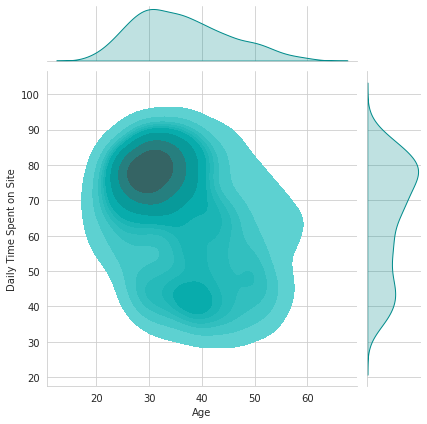

In [13]:
# age vs. daily time spent on the website
sns.jointplot(kind='kde', x='Age', y='Daily Time Spent on Site', data=ad, 
              color='darkcyan',shade=True, fill=True);

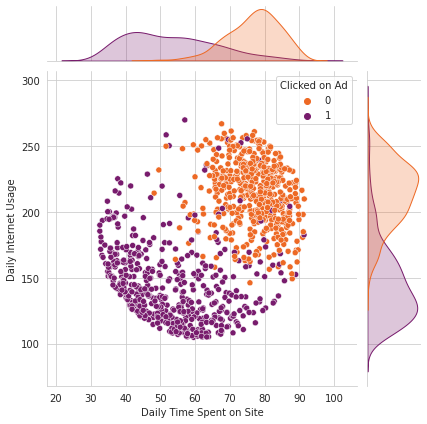

In [14]:
# daily time spent on the website vs. daily internet usage
sns.jointplot(x='Daily Time Spent on Site', y='Daily Internet Usage', data=ad, 
              hue='Clicked on Ad', palette='inferno_r');

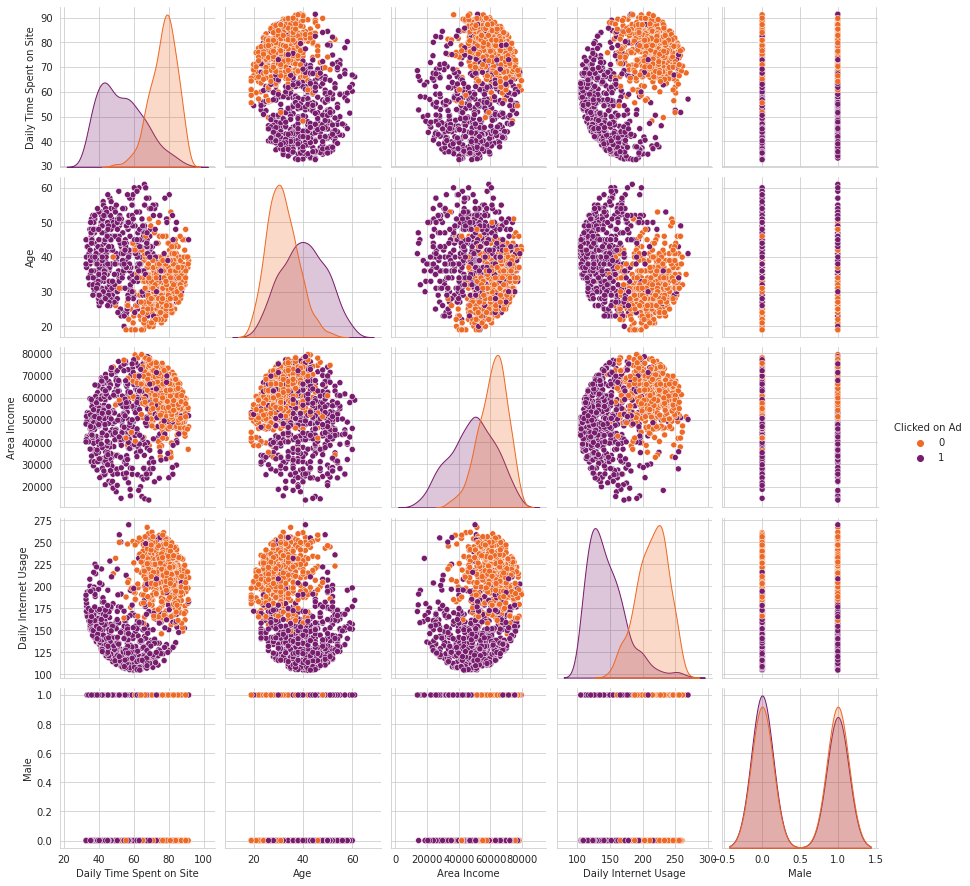

In [15]:
sns.pairplot(ad, hue='Clicked on Ad', palette='inferno_r');

# Preprocessing Data

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = ad[['Daily Time Spent on Site', 'Age', 'Area Income','Daily Internet Usage', 'Male']]
y = ad['Clicked on Ad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
lr_acc = accuracy_score(y_test, lr_pred)

print(f'Model Accuracy: {lr_acc}')
print(f'\nConfusion Matrix: \n{confusion_matrix(y_test, lr_pred)}')
print(f'\nClassification Report: \n{classification_report(y_test, lr_pred)}')

Model Accuracy: 0.9666666666666667

Confusion Matrix: 
[[143   6]
 [  4 147]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       149
           1       0.96      0.97      0.97       151

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



# K-Nearest Neighbors

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

knn_acc = accuracy_score(y_test, knn_pred)

print(f'Model Accuracy: {knn_acc}')
print(f'\nConfusion Matrix: \n{confusion_matrix(y_test, knn_pred)}')
print(f'\nClassification Report: \n{classification_report(y_test, knn_pred)}')

Model Accuracy: 0.95

Confusion Matrix: 
[[141   8]
 [  7 144]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       149
           1       0.95      0.95      0.95       151

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



## Choosing a K-Value

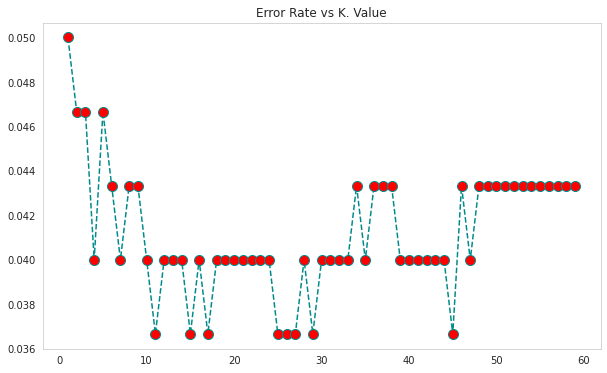

In [19]:
# getting the error rate
error_rate = []

for i in range (1, 60):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

# plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 60), error_rate, color='darkcyan', linestyle='--',
        marker='o', markersize=10, markerfacecolor='red')
plt.title('Error Rate vs K. Value')
plt.xlabel='K'
plt.ylabel='Error Rate'
plt.grid(False)
plt.show()

## Retrain the new K-Value

In [20]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=26)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

knn_acc = accuracy_score(y_test, knn_pred)

print(f'Model Accuracy: {knn_acc}')
print(f'\nConfusion Matrix: \n{confusion_matrix(y_test, knn_pred)}')
print(f'\nClassification Report: \n{classification_report(y_test, knn_pred)}')

Model Accuracy: 0.9633333333333334

Confusion Matrix: 
[[147   2]
 [  9 142]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       149
           1       0.99      0.94      0.96       151

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



# Model Comparison

In [21]:
models = pd.DataFrame({
    'Model':['Logistic Regression','KNN'],
    'Accuracy Score' :[lr_acc, knn_acc]
})

models.sort_values(by='Accuracy Score', ascending=False)

,Model,Accuracy Score
0,Logistic Regression,0.966667
1,KNN,0.963333


### Thank you for your time!
#### I appreciate you reading this far. If you have any comments and/or tips for improvement, **please leave a comment!**
#### Cheers! :)